In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



In [10]:
# Categorical Variables
ML_CATEGORICAL = ["geocode", "the_west", "event_type", "is_claimed", "suicide", "targets", "weapons", 
                  "intensity", "conflict"]

# Hyperparameters for RandomForest
hyperparameters = {
    'n_estimators': [100, 150],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt','log2'],
    'bootstrap': [True, False]
}

TRAINING_DATA = "../../../02_data/processed/ml_testtraining.csv"
NEW_DATA = "../../../02_data/processed/ml_final.csv"





In [11]:
# Load and process datasets
def pf_LoadClean(filepath, training_features=None):
    """Load and preprocess the dataset."""
    df = pd.read_csv(filepath)

    group_counts = df['Group'].value_counts()
    df = df[df['Group'].isin(group_counts[group_counts > 5].index)]

    df = pd.get_dummies(df, columns=ML_CATEGORICAL)

    label_encoder = LabelEncoder()
    df['Group'] = label_encoder.fit_transform(df['Group'])

    if training_features is not None:
        for col in training_features:
            if col not in df.columns:
                df[col] = 0
        df = df[training_features]

    return df, label_encoder

def pf_TrainModel(df, target_variable, hyperparameters):
    df = df.dropna()
    X = df.drop(target_variable, axis=1)
    y = df[target_variable]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    ros = RandomOverSampler(random_state=123)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    model = RandomForestClassifier()
    clf = GridSearchCV(model, hyperparameters, scoring='accuracy', cv=5)
    clf.fit(X_train_resampled, y_train_resampled)

    return clf, X_test, y_test

def pf_Plot_FeatureImportance(clf):
    feature_importance = clf.best_estimator_.feature_importances_
    sorted_idx = feature_importance.argsort()
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.xlabel("Random Forest Feature Importance")
    plt.show()

def pf_EvaluateModel(clf, X_test, y_test, group_encoder):
    predictions = clf.predict(X_test)
    original_labels = group_encoder.inverse_transform(predictions)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy:.2f}")
    return accuracy, original_labels

def pf_PredictNewData(filepath, clf, group_encoder, training_features):
    df_new, _ = pf_LoadClean(filepath, training_features=training_features)
    X_new = df_new.drop('Group', axis=1)
    predictions_new = clf.predict(X_new)
    original_labels_new = group_encoder.inverse_transform(predictions_new)
    return original_labels_new



In [12]:
# Load and preprocess data
df_evaluate, group_encoder = pf_LoadClean(TRAINING_DATA)

# Train the model
clf, X_test, y_test = pf_TrainModel(df_evaluate, 'Group', hyperparameters)



In [15]:
# Get list of feature names after preprocessing
training_features = df_evaluate.drop('Group', axis=1).columns.tolist()







In [13]:
# Evaluate the model
accuracy, original_labels = pf_EvaluateModel(clf, X_test, y_test, group_encoder)
print("Original Labels of Predictions:", original_labels)

Model Accuracy: 0.64
Original Labels of Predictions: ['Islamic State (IS)' 'Abu Sayyaf' 'Islamic State West Africa (ISWA)' ...
 'Wrath of Olives' 'FARC' 'Anti-junta armed group (undetermined)']


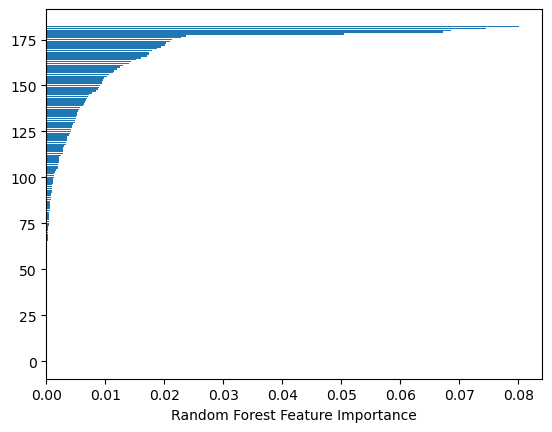

In [14]:
# Plot feature importance
pf_Plot_FeatureImportance(clf)

In [20]:
# Predict on new data

predicted_labels = pf_PredictNewData(NEW_DATA, clf, group_encoder, training_features)
print("Predicted Group Names:", predicted_labels)

Predicted Group Names: ['Kanglei Yawol Kanna Lup (KYKL)' 'Al-Qaeda in Iraq (AQI)'
 'Al-Qaeda in Iraq (AQI)' ... 'JNIM' 'JNIM' 'JNIM']


In [17]:
training_features

['Unnamed: 0',
 'year',
 'date',
 'deaths_total',
 'hostages_total',
 'injured_total',
 'terrorists_killed',
 'latitude',
 'longitude',
 'geocode_AFG',
 'geocode_AGO',
 'geocode_ARE',
 'geocode_ARG',
 'geocode_ARM',
 'geocode_AUS',
 'geocode_AUT',
 'geocode_AZE',
 'geocode_BEL',
 'geocode_BEN',
 'geocode_BFA',
 'geocode_BGD',
 'geocode_BHR',
 'geocode_BRA',
 'geocode_CAF',
 'geocode_CAN',
 'geocode_CHE',
 'geocode_CHL',
 'geocode_CHN',
 'geocode_CIV',
 'geocode_CMR',
 'geocode_COD',
 'geocode_COL',
 'geocode_CYP',
 'geocode_CZE',
 'geocode_DEU',
 'geocode_DJI',
 'geocode_DNK',
 'geocode_DZA',
 'geocode_ECU',
 'geocode_EGY',
 'geocode_ESP',
 'geocode_ETH',
 'geocode_FIN',
 'geocode_FRA',
 'geocode_GBR',
 'geocode_GEO',
 'geocode_GRC',
 'geocode_IDN',
 'geocode_IND',
 'geocode_IRL',
 'geocode_IRN',
 'geocode_IRQ',
 'geocode_ISR',
 'geocode_ITA',
 'geocode_JOR',
 'geocode_KAZ',
 'geocode_KEN',
 'geocode_KWT',
 'geocode_LBN',
 'geocode_LBY',
 'geocode_LKA',
 'geocode_MAR',
 'geocode_MEX',


In [18]:
def pf_PredictNewData(filepath, clf, group_encoder, training_features):
    df_new, _ = pf_LoadClean(filepath, training_features=training_features)
    # Check if 'Group' column exists before dropping
    if 'Group' in df_new.columns:
        X_new = df_new.drop('Group', axis=1)
    else:
        X_new = df_new  # If 'Group' column does not exist, use df_new as is
    predictions_new = clf.predict(X_new)
    original_labels_new = group_encoder.inverse_transform(predictions_new)
    return original_labels_new

In [24]:
def pf_PredictNewData(filepath, clf, group_encoder, training_features):
    df_new, _ = pf_LoadClean(filepath, training_features=training_features)
    # Check if 'Group' column exists before dropping
    if 'Group' in df_new.columns:
        X_new = df_new.drop('Group', axis=1)
    else:
        X_new = df_new  # If 'Group' column does not exist, use df_new as is
    predictions_new = clf.predict(X_new)
    original_labels_new = group_encoder.inverse_transform(predictions_new)
    return original_labels_new

In [21]:
def pf_PredictNewData(filepath, clf, group_encoder, training_features):
    df_new, _ = pf_LoadClean(filepath, training_features=training_features)
    if 'Group' in df_new.columns:
        X_new = df_new.drop('Group', axis=1)
    else:
        X_new = df_new
    predictions_new = clf.predict(X_new)
    original_labels_new = group_encoder.inverse_transform(predictions_new)
    df_new['Predicted_Group'] = original_labels_new
    return df_new

In [25]:
df_with_predictions = pf_PredictNewData(NEW_DATA, clf, group_encoder, df_evaluate)






ValueError: Boolean array expected for the condition, not object

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Categorical Variables
ML_CATEGORICAL = ["geocode", "the_west", "event_type", "is_claimed", "suicide", "targets", "weapons", 
                  "intensity", "conflict"]

# Hyperparameters for RandomForest
hyperparameters = {
    'n_estimators': [100, 150],
    'max_depth': [6, 8, 10],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt','log2'],
    'bootstrap': [True, False]
}

TRAINING_DATA = "../../../02_data/processed/ml_testtraining.csv"
NEW_DATA = "../../../02_data/processed/ml_final.csv"

# Function to load and clean data
def pf_LoadClean(filepath, training_features=None):
    df = pd.read_csv(filepath)
    group_counts = df['Group'].value_counts()
    df = df[df['Group'].isin(group_counts[group_counts > 5].index)]
    df = pd.get_dummies(df, columns=ML_CATEGORICAL)
    label_encoder = LabelEncoder()
    df['Group'] = label_encoder.fit_transform(df['Group'])
    if training_features is not None:
        for col in training_features:
            if col not in df.columns:
                df[col] = 0
        df = df[training_features]
    return df, label_encoder

# Function to train the model
def pf_TrainModel(df, target_variable, hyperparameters):
    df = df.dropna()
    X = df.drop(target_variable, axis=1)
    y = df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
    ros = RandomOverSampler(random_state=123)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    model = RandomForestClassifier()
    clf = GridSearchCV(model, hyperparameters, scoring='accuracy', cv=5)
    clf.fit(X_train_resampled, y_train_resampled)
    return clf, X_test, y_test

# Function to plot feature importance
def pf_Plot_FeatureImportance(clf):
    feature_importance = clf.best_estimator_.feature_importances_
    sorted_idx = feature_importance.argsort()
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.xlabel("Random Forest Feature Importance")
    plt.show()

# Function to evaluate the model
def pf_EvaluateModel(clf, X_test, y_test, group_encoder):
    predictions = clf.predict(X_test)
    original_labels = group_encoder.inverse_transform(predictions)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Model Accuracy: {accuracy:.2f}")
    return accuracy, original_labels

# Modified function to predict new data and add predictions back onto the dataset
def pf_PredictNewData(filepath, clf, group_encoder, training_features):
    df_new, _ = pf_LoadClean(filepath, training_features=training_features)
    if 'Group' in df_new.columns:
        X_new = df_new.drop('Group', axis=1)
    else:
        X_new = df_new
    predictions_new = clf.predict(X_new)
    original_labels_new = group_encoder.inverse_transform(predictions_new)
    df_new['Predicted_Group'] = original_labels_new
    return df_new




In [ ]:
# Example usage:
# Load and preprocess data
df_evaluate, group_encoder = pf_LoadClean(TRAINING_DATA)
# Train the model
clf, X_test, y_test = pf_TrainModel(df_evaluate, 'Group', hyperparameters)



In [36]:
# Evaluate the model
accuracy, original_labels = pf_EvaluateModel(clf, X_test, y_test, group_encoder)

C:\Users\ThomasMorgan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Model Accuracy: 0.64
Precision (weighted): 0.00
Recall (weighted): 0.00
F1 Score (weighted): 0.00
Confusion Matrix:
[[59  0  0 ...  0  0  0]
 [ 0 44  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]]
ROC AUC: 0.00
Log Loss: 0.00
MCC: 0.63


ValueError: too many values to unpack (expected 2)

In [27]:
# Predict on new data and add predictions back onto the dataset
df_with_predictions = pf_PredictNewData(NEW_DATA, clf, group_encoder, df_evaluate.drop('Group', axis=1).columns.tolist())
# Write the dataframe with predictions to a CSV file
df_with_predictions.to_csv("../../../02_data/processed/ml_predictions.csv", index=False)

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.preprocessing import LabelBinarizer
import numpy as np

def pf_EvaluateModel(clf, X_test, y_test, group_encoder):
    predictions = clf.predict(X_test)
    predicted_probs = clf.predict_proba(X_test)
    
    # Handling the case where not all classes are predicted or present in the test set
    lb = LabelBinarizer()
    lb.fit(group_encoder.classes_)  # Fit on all classes to ensure consistent columns
    y_test_bin = lb.transform(y_test)
    predictions_bin = lb.transform(predictions)

    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test_bin, predictions_bin, average='weighted', zero_division=0)
    recall = recall_score(y_test_bin, predictions_bin, average='weighted', zero_division=0)
    f1 = f1_score(y_test_bin, predictions_bin, average='weighted')
    conf_matrix = confusion_matrix(y_test, predictions)
    try:
        roc_auc = roc_auc_score(y_test_bin, predicted_probs, multi_class='ovr', average='weighted')
    except ValueError as e:
        print(f"ROC AUC score calculation error: {e}")
        roc_auc = None
    logloss = log_loss(y_test_bin, predicted_probs)
    mcc = matthews_corrcoef(y_test, predictions)

    # Print metrics
    print(f"Model Accuracy: {accuracy:.2f}")
    print(f"Precision (weighted): {precision:.2f}")
    print(f"Recall (weighted): {recall:.2f}")
    print(f"F1 Score (weighted): {f1:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Log Loss: {logloss:.2f}")
    print(f"MCC: {mcc:.2f}")

    original_labels = group_encoder.inverse_transform(predictions)
    return accuracy, precision, recall, f1, conf_matrix, roc_auc, logloss, mcc, original_labels
